In [4]:
import itertools as it
import time
from utils import *
# from pysat.solvers import Glucose3

import numpy as np
from scipy import sparse

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# CELL
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import scipy.sparse as sp
from scipy.sparse import load_npz

import torch

from cell.utils import link_prediction_performance
from cell.cell import Cell, EdgeOverlapCriterion, LinkPredictionCriterion
from cell.graph_statistics import compute_graph_statistics


class GCN(torch.nn.Module):
    def __init__(self, node_features):
        super().__init__()
        # GCN initialization
        self.conv1 = GCNConv(node_features, 128)
        self.conv2 = GCNConv(128, 128)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return x

In [5]:
from pysat.formula import CNF
from pysat.solvers import Solver


instances = [
    "countbitssrl016.processed.cnf",
    "smulo016.processed.cnf",
    "cmu-bmc-longmult15.processed.cnf",
    "countbitsrotate016.processed.cnf",
    "aes_32_3_keyfind_2.processed.cnf",
    "sat_prob_83.processed.cnf",
]

for sat_name in instances:
    sat_path = f'./dataset/formulas/{sat_name}'
    num_vars, num_clauses, sat_instance = read_sat(sat_path)
    max_len = max([len(clause) for clause in sat_instance])

    lig_adjacency_matrix, lig_weighted_adjacency_matrix = sat_to_lig_adjacency_matrix(sat_instance, num_vars)
    edge_index = torch.tensor(np.array(lig_adjacency_matrix.nonzero()), dtype=torch.long)
    edge_value = lig_weighted_adjacency_matrix[lig_adjacency_matrix.nonzero()]

    embeddings = torch.load(f'./model/embeddings/{sat_name}.pt')
    embeddings.requires_grad = False
    x = embeddings
    data = Data(x=x, edge_index=edge_index)

    # training for GNN
    model = GCN(50)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.train()
    for epoch in range(500):
        optimizer.zero_grad()
        out = model(data)
        src, dst = edge_index
        score = (out[src] * out[dst]).sum(dim=-1)
        loss = F.mse_loss(score, torch.tensor(edge_value, dtype=torch.float))
        loss.backward()
        optimizer.step()
        # print(f'epoch: {epoch}, loss: {loss.item()}')

    # training for CELL
    sparse_matrix = sparse.csr_matrix(lig_adjacency_matrix)
    cell_model = Cell(A=sparse_matrix,
                H=10,
                callbacks=[EdgeOverlapCriterion(invoke_every=10, edge_overlap_limit=.80)])
    cell_model.train(steps=400,
                optimizer_fn=torch.optim.Adam,
                optimizer_args={'lr': 0.1,
                                'weight_decay': 1e-7})

    # generate WLIG
    generated_graph = cell_model.sample_graph()
    graph_prime = generated_graph.A
    graph_prime = graph_post_process(graph_prime)
    edge_index_prime = torch.tensor(graph_prime.nonzero(), dtype=torch.long)
    x = embeddings
    data_prime = Data(x=x, edge_index = edge_index_prime)
    out = model(data_prime)
    src, dst = edge_index_prime
    score = (out[src] * out[dst]).sum(dim=-1)
    weight = score.detach().numpy()
    weight[weight <= 1] = 1
    weight = np.rint(weight).astype(int)
    weighted_graph_prime = np.copy(graph_prime)
    weighted_graph_prime[weighted_graph_prime.nonzero()] = weight

    # OWC decoding
    clique_candidates = get_clique_candidates(graph_prime, max_len, 3)
    cliques = lazy_clique_edge_cover(np.copy(weighted_graph_prime), clique_candidates, num_clauses)
    owc_instance = cliques_to_sat(cliques)

    # tabu decoding from WLIG
    clique_candidates = get_clique_candidates(graph_prime, 3, 3)
    # print(f'number of cliques: {len(clique_candidates)}')
    cliques = tabu_lazy_greedy_cover(np.copy(weighted_graph_prime), clique_candidates, num_clauses, num_vars, 3)
    tabu_instance = cliques_to_sat(cliques)

    # write to file
    with open(f'./result/hardness/w2sat/{sat_name}', "w") as f:
        f.write(f"p cnf {num_vars} {len(owc_instance)}\n")
        for clause in owc_instance:
            f.write(f"{' '.join([str(v) for v in clause])} 0\n")

    with open(f'./result/hardness/w2sat-tabu/{sat_name}', "w") as f:
        f.write(f"p cnf {num_vars} {len(tabu_instance)}\n")
        for clause in tabu_instance:
            f.write(f"{' '.join([str(v) for v in clause])} 0\n")


    # cnf = CNF(from_clauses=sat_instance)
    # s = Solver(name='g3', bootstrap_with=cnf)
    # s.solve()
    # print(s.accum_stats())

Step:  10/400 Loss: 6.23345 Edge-Overlap: 0.078 Total-Time: 2
Step:  20/400 Loss: 4.55819 Edge-Overlap: 0.323 Total-Time: 4
Step:  30/400 Loss: 3.95852 Edge-Overlap: 0.440 Total-Time: 6
Step:  40/400 Loss: 3.67128 Edge-Overlap: 0.512 Total-Time: 9
Step:  50/400 Loss: 3.51283 Edge-Overlap: 0.559 Total-Time: 11
Step:  60/400 Loss: 3.41049 Edge-Overlap: 0.593 Total-Time: 13
Step:  70/400 Loss: 3.33765 Edge-Overlap: 0.618 Total-Time: 15
Step:  80/400 Loss: 3.28255 Edge-Overlap: 0.633 Total-Time: 18
Step:  90/400 Loss: 3.23872 Edge-Overlap: 0.662 Total-Time: 20
Step: 100/400 Loss: 3.20243 Edge-Overlap: 0.675 Total-Time: 22
Step: 110/400 Loss: 3.17211 Edge-Overlap: 0.684 Total-Time: 24
Step: 120/400 Loss: 3.14618 Edge-Overlap: 0.697 Total-Time: 27
Step: 130/400 Loss: 3.12401 Edge-Overlap: 0.709 Total-Time: 29
Step: 140/400 Loss: 3.10485 Edge-Overlap: 0.717 Total-Time: 31
Step: 150/400 Loss: 3.08824 Edge-Overlap: 0.723 Total-Time: 33
Step: 160/400 Loss: 3.07361 Edge-Overlap: 0.737 Total-Time:

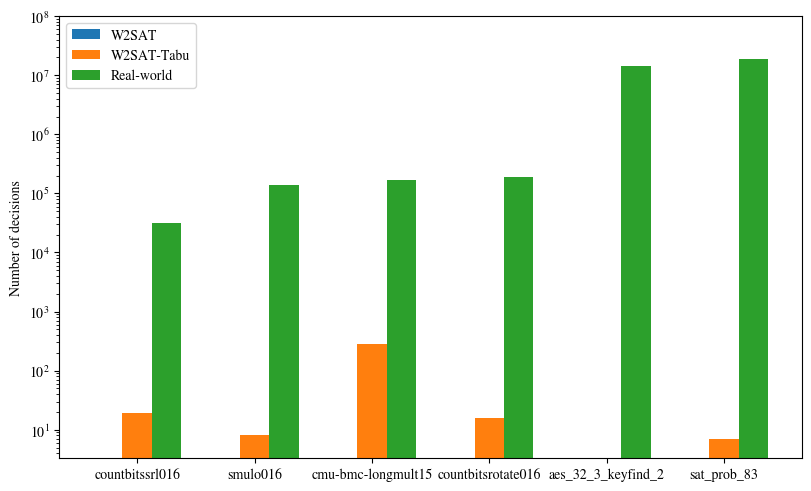

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

instances = [
    "countbitssrl016",
    "smulo016",
    "cmu-bmc-longmult15",
    "countbitsrotate016",
    "aes_32_3_keyfind_2",
    "sat_prob_83",
]

hardness = {
    'W2SAT': [0, 0, 0, 0, 0, 0],
    'W2SAT-Tabu': [19, 8, 286, 16, 0, 7],
    'Real-world': [31535, 139816, 171206, 188682, 14467460, 18642176],
}


x = np.arange(len(instances))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in hardness.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of decisions')
# ax.set_title('hardness by instances')
ax.set_xticks(x + width, instances)
ax.legend(loc='upper left')
ax.set_yscale('log')
ax.set_ylim(0, 10**8)
fig.set_figwidth(8)

plt.show()